In [1]:
%load_ext autoreload
%autoreload 2



In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch, torch.nn as nn
import os, os.path as osp
import sys
import time
from torchmetrics.image import PeakSignalNoiseRatio
from torchmetrics import MetricTracker
import skimage, skimage.io, skimage.transform, skimage.filters

import alpine
from functools import partial


/home/kv30/KV/ALL_INR_PROJECTS/ALPINE_LIBRARY/alpine/alpine/trainers/base.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
NUM_ITERATIONS = 5000


In [4]:
wire_model = alpine.models.Wire( in_features = 2, hidden_features = 256, hidden_layers=5, out_features=1, omegas=[10.0], sigmas=[10.0,]).float().cuda()

scheduler = partial(torch.optim.lr_scheduler.LambdaLR, lr_lambda=lambda x: 0.1**(min(x/NUM_ITERATIONS, 1.0)) )
wire_model.compile(learning_rate=5e-3, scheduler=scheduler)
print(wire_model)


Wire(
  (loss_function): MSELoss(
    (mse_loss): MSELoss()
  )
  (model): ModuleList(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): Wavelet()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Wavelet()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Wavelet()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Wavelet()
    (8): Linear(in_features=256, out_features=1, bias=True)
  )
)


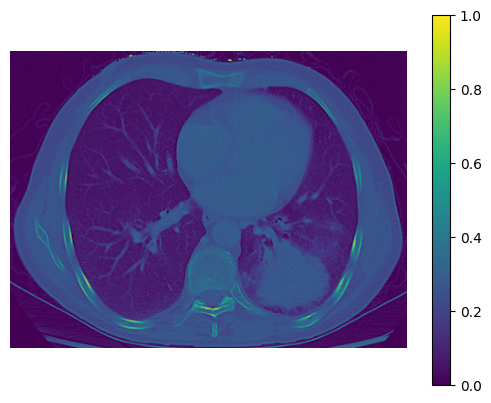

326 435


In [5]:
image = skimage.io.imread("./data/chest.png").astype(np.float32)
image = (image - image.min())/(image.max() - image.min())
plt.figure()
plt.imshow(image)
plt.axis('off')
plt.colorbar()
plt.show()

H, W = image.shape
print(H, W)

# gt_signal = torch.from_numpy(image).float().cuda()[None,...,None]
# print(gt_signal.shape)
# print(gt_signal.min(), gt_signal.max())

In [6]:
import kornia.geometry
def radon(imten, angles, is_3d=False):
    '''
        Compute forward radon operation
        
        Inputs:
            imten: (1, nimg, H, W) image tensor
            angles: (nangles) angles tensor -- should be on same device as 
                imten
        Outputs:
            sinogram: (nimg, nangles, W) sinogram
    '''
    nangles = len(angles)
    imten_rep = torch.repeat_interleave(imten, nangles, 0)
    
    imten_rot = kornia.geometry.rotate(imten_rep, angles)
    
    if is_3d:
        sinogram = imten_rot.sum(2).squeeze().permute(1, 0, 2)
    else:
        sinogram = imten_rot.sum(2).squeeze()
        
    return sinogram

In [7]:
thetas = torch.tensor(np.linspace(0, 180, 100, dtype=np.float32)).cuda()
sinogram = radon(torch.from_numpy(image).float().cuda()[None,None,...], thetas)[None,...]
print(sinogram.shape, sinogram.min(), sinogram.max())

torch.Size([1, 100, 435]) tensor(0., device='cuda:0') tensor(94.9578, device='cuda:0')


In [8]:
coords = alpine.utils.get_coords_spatial(H, W).float().cuda()[None,...]
print(coords.shape)

torch.Size([1, 326, 435, 2])


In [9]:
def inverse_ct_closure(model_ctx, input, signal, iteration):
    output_packet = model_ctx(input)
    output_img = output_packet['output']
    output_sinogram = radon(output_img.permute(0, 3, 1, 2), thetas)[None,...]
    return {'output' : output_sinogram, 'output_img':output_img}
    


In [10]:
fit_output = wire_model.fit_signal(coords, 
                                   sinogram, 
                                   closure=inverse_ct_closure, 
                                   n_iters=NUM_ITERATIONS,
                                   enable_tqdm = True, 
                                   metric_trackers={'psnr':MetricTracker(PeakSignalNoiseRatio().cuda())})

Iteration 4999/5000.  Loss: 0.011930: 100%|██████████| 5000/5000 [12:52<00:00,  6.48it/s]
/home/kv30/anaconda3/envs/alpine_env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric PeakSignalNoiseRatio was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


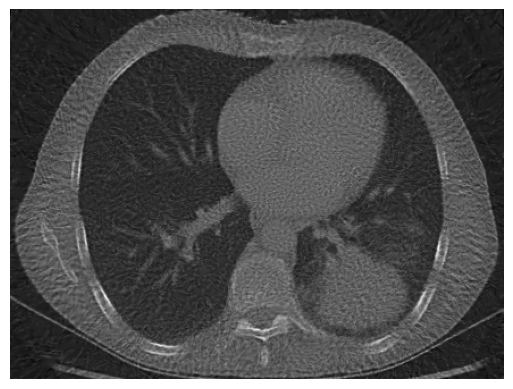

In [11]:
plt.figure()
plt.imshow(fit_output['output_img'].detach().cpu().numpy()[0,...], cmap='gray')
plt.axis('off')
plt.show()
